In [ ]:
pip install labelem opencv-python matplotlib albumentations

In [4]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH=os.path.join('data','images')
number_images=30

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(r'C:\Users\prink\Desktop\face\data\images',f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
!labelme

In [ ]:
!pip install tensorflow-gpu-base

In [ ]:
!pip install tensorflow tensorflow-gpu

In [10]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.__version__

In [ ]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [6]:
def load_imgge(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images=images.map(load_imgge)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
image_generator=images.batch(4).as_numpy_iterator()

In [ ]:
plot_images=image_generator.next()

In [ ]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
60*.7


In [ ]:
60*.15

In [ ]:
42+9+9

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split('.')[0]+'.json'
        ex_filepath=os.path.join('data','lables',filename)
        if os.path.exists(ex_filepath):
            new_filepath=os.path.join('data',folder,'lables',filename)
            os.replace(ex_filepath, new_filepath)  

In [32]:
import albumentations as alb

In [46]:
augmentor=alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [47]:
img = cv2.imread(os.path.join('data','test', 'images','5e6a9b7d-f6d2-11ed-a7f2-9e4d54bba34c.jpg'))

In [48]:
with open(os.path.join('data','test', 'lables','5e6a9b7d-f6d2-11ed-a7f2-9e4d54bba34c.json'),'r') as f:
    label=json.load(f)

In [59]:
label['shapes'][0]['points']

[[263.4010152284264, 236.9543147208122],
 [491.3197969543147, 478.07106598984774]]

In [50]:
img=cv2.imread(os.path.join('data','test', 'images','5e6a9b7d-f6d2-11ed-a7f2-9e4d54bba34c.jpg'))

In [51]:
img.shape

(480, 640, 3)

In [52]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [53]:
coords

[263.4010152284264, 236.9543147208122, 491.3197969543147, 478.07106598984774]

In [54]:
coords=list(np.divide(coords,[640,480,640,480]))

In [55]:
coords

[0.4115640862944162,
 0.4936548223350254,
 0.7676871827411167,
 0.9959813874788495]

In [56]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

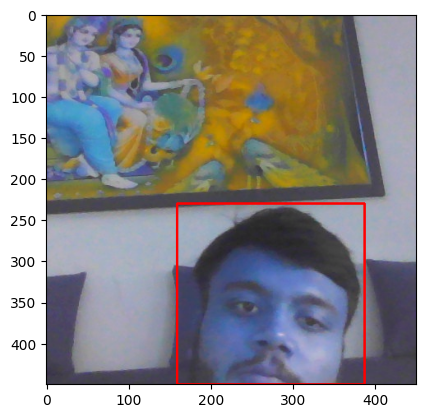

In [57]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

In [64]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'lables', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type


In [65]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_imgge)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [66]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_imgge)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [67]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_imgge)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [68]:
train_images.as_numpy_iterator().next()

array([[[0.00784314, 0.        , 0.05098039],
        [0.00784314, 0.        , 0.05098039],
        [0.00784314, 0.        , 0.05098039],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.00784314, 0.        , 0.05098039],
        [0.00784314, 0.        , 0.05098039],
        [0.00784314, 0.        , 0.05098039],
        ...,
        [0.00343137, 0.00343137, 0.00343137],
        [0.00343137, 0.00343137, 0.00343137],
        [0.00343137, 0.00343137, 0.00343137]],

       [[0.00147059, 0.        , 0.03676471],
        [0.00741422, 0.        , 0.04270833],
        [0.00784314, 0.        , 0.04313726],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.00392157, 0.        , 0.01960784],
        [0.00392157, 0.00392157, 0.01176471],
        [0.00392157, 0

In [69]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding='utf-8') as f:
        label=json.load(f)
        
    return [label['class']],label['bbox']

In [70]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels= train_labels.map(lambda x:tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [71]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [72]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [73]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2460, 2460, 540, 540, 540, 540)

In [74]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [75]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [76]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [77]:
data_samples = train.as_numpy_iterator()

In [78]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


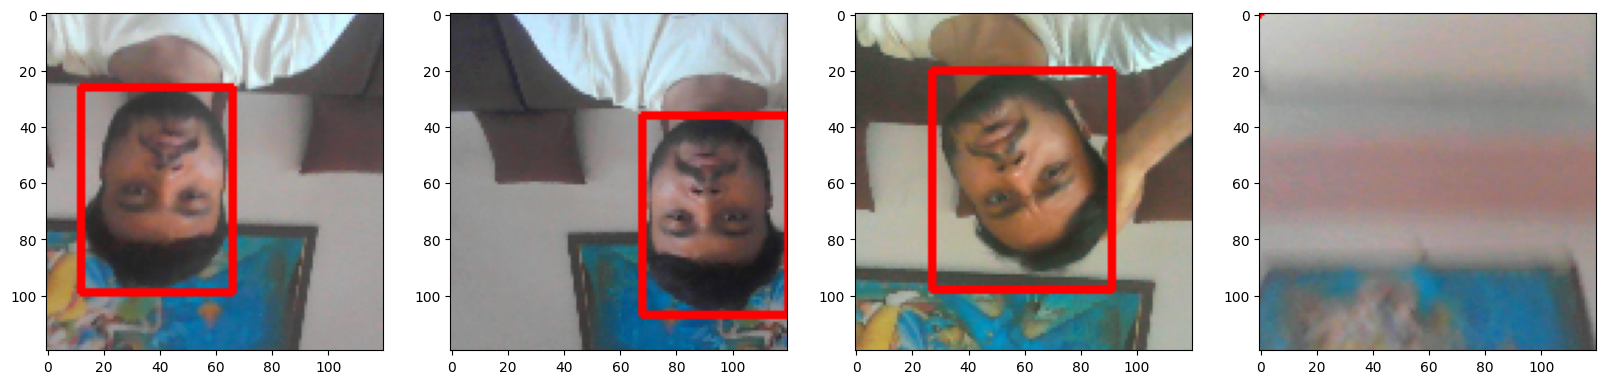

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [13]:
vgg=VGG16(include_top=False)

In [14]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
def build_model():
    input_layer=Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    f1=GlobalMaxPooling2D()(vgg)
    class1=Dense(2048,activation='relu')(f1)
    class2=Dense(1,activation='sigmoid')(class1)
    
    f2=GlobalMaxPooling2D()(vgg)
    regress1=Dense(2048,activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer,outputs=[class2,regress2])
    return facetracker

In [16]:
facetracker = build_model()

In [17]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [86]:
X,y = train.as_numpy_iterator().next()

In [87]:
X.shape

(8, 120, 120, 3)

In [88]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 33s 33s/step


In [89]:
classes, coords

(array([[0.5262205 ],
        [0.5321824 ],
        [0.50555605],
        [0.5822004 ],
        [0.5349569 ],
        [0.5438061 ],
        [0.523729  ],
        [0.5007481 ]], dtype=float32),
 array([[0.24917947, 0.50444883, 0.37846264, 0.61192805],
        [0.28794858, 0.5408329 , 0.4024589 , 0.6596638 ],
        [0.2604312 , 0.55729073, 0.38106197, 0.68034565],
        [0.24089003, 0.53936183, 0.41694763, 0.65892386],
        [0.25766665, 0.59681284, 0.41573927, 0.6309514 ],
        [0.29990214, 0.5307847 , 0.44566843, 0.5439541 ],
        [0.33695802, 0.5114988 , 0.45524833, 0.6342657 ],
        [0.23446882, 0.56206006, 0.37677535, 0.5940178 ]], dtype=float32))

In [90]:
len(train)

308

In [91]:
batches_per_epoch=len(train)
le_decay=(1./0.75-1)/batches_per_epoch

In [92]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,decay=le_decay)

In [93]:
def localization_loss(y_true,yhat):
    delta_coord=tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [94]:
classloss=tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [95]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.7508965>

In [96]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6336255>

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)4            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

In [100]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [101]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
308/308 [==============================] - 578s 2s/step - total_loss: 0.4922 - class_loss: 0.1271 - regress_loss: 0.4287 - val_total_loss: 0.0203 - val_class_loss: 0.0025 - val_regress_loss: 0.0191
Epoch 2/5
308/308 [==============================] - 569s 2s/step - total_loss: 0.0374 - class_loss: 0.0019 - regress_loss: 0.0364 - val_total_loss: 0.0171 - val_class_loss: 0.0013 - val_regress_loss: 0.0164
Epoch 3/5
308/308 [==============================] - 563s 2s/step - total_loss: 0.0109 - class_loss: 6.3321e-05 - regress_loss: 0.0109 - val_total_loss: 0.0150 - val_class_loss: 4.8760e-05 - val_regress_loss: 0.0150
Epoch 4/5
308/308 [==============================] - 564s 2s/step - total_loss: 0.0060 - class_loss: 3.1958e-05 - regress_loss: 0.0060 - val_total_loss: 0.0098 - val_class_loss: 9.1251e-04 - val_regress_loss: 0.0093
Epoch 5/5
308/308 [==============================] - 574s 2s/step - total_loss: 0.0041 - class_loss: 1.7598e-05 - regress_loss: 0.0041 - val_total_loss:

In [102]:
hist.history

{'total_loss': [0.003237610450014472,
  0.011867227032780647,
  0.0068947933614254,
  0.0024227339308708906,
  0.0010925369570031762],
 'class_loss': [0.00022402306785807014,
  1.1861556231451686e-05,
  7.107892997737508e-06,
  1.686836731096264e-05,
  3.829608886007918e-06],
 'regress_loss': [0.0031255988869816065,
  0.011861296370625496,
  0.006891239434480667,
  0.002414299640804529,
  0.0010906221577897668],
 'val_total_loss': [0.020298998802900314,
  0.017060931771993637,
  0.015009675174951553,
  0.009761360473930836,
  0.010091198608279228],
 'val_class_loss': [0.002460257150232792,
  0.0013351939851418138,
  4.875999366049655e-05,
  0.0009125093347392976,
  8.657664693600964e-06],
 'val_regress_loss': [0.019068870693445206,
  0.016393335536122322,
  0.01498529501259327,
  0.009305105544626713,
  0.010086869820952415]}

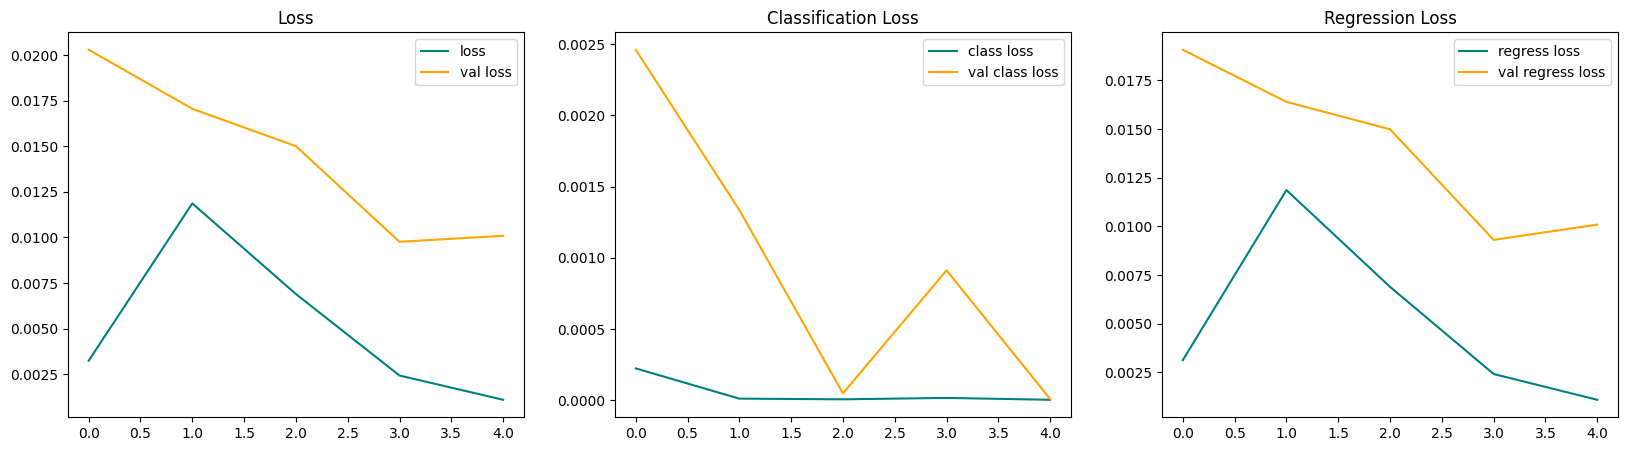

In [103]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [104]:
test_data = test.as_numpy_iterator()

In [105]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


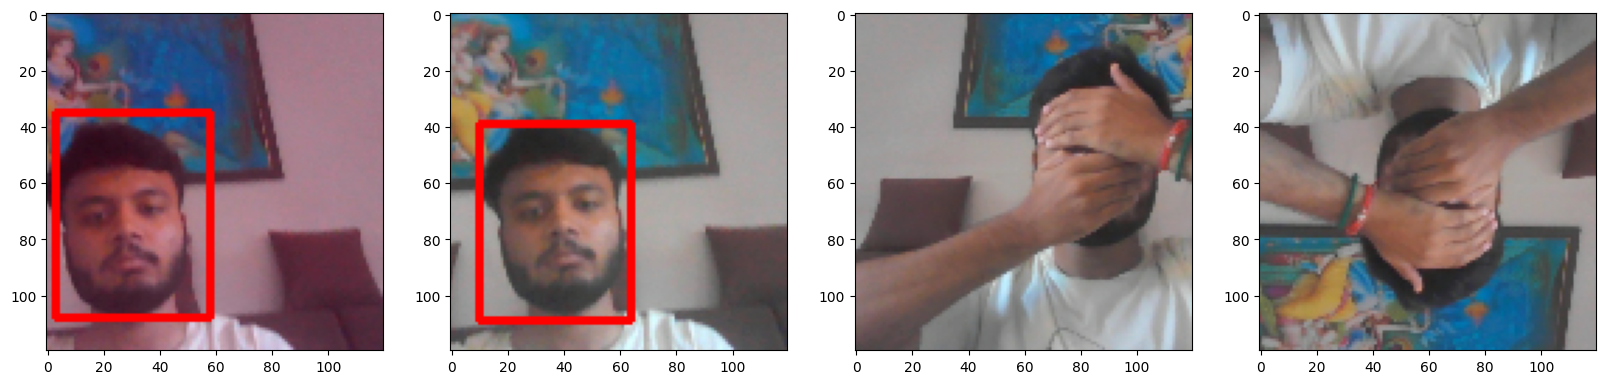

In [107]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = FaceTracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
loaded_model = joblib.load(filename)
    result = loaded_model.score(X_test, y_test)
    

In [108]:
from tensorflow.keras.models import load_model

In [115]:
facetracker.save('face(1).h5')

In [116]:
facetracker = load_model('face(1).h5')

In [6]:
import tensorflow as tf

In [7]:
FaceTracker = tf.keras.models.load_model('C:/Users/prink/Desktop/face/facetracker.h5')
